## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')
# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        #img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #cv2.imshow('img', img)
        #cv2.waitKey(500)

cv2.destroyAllWindows()

## Undistort images

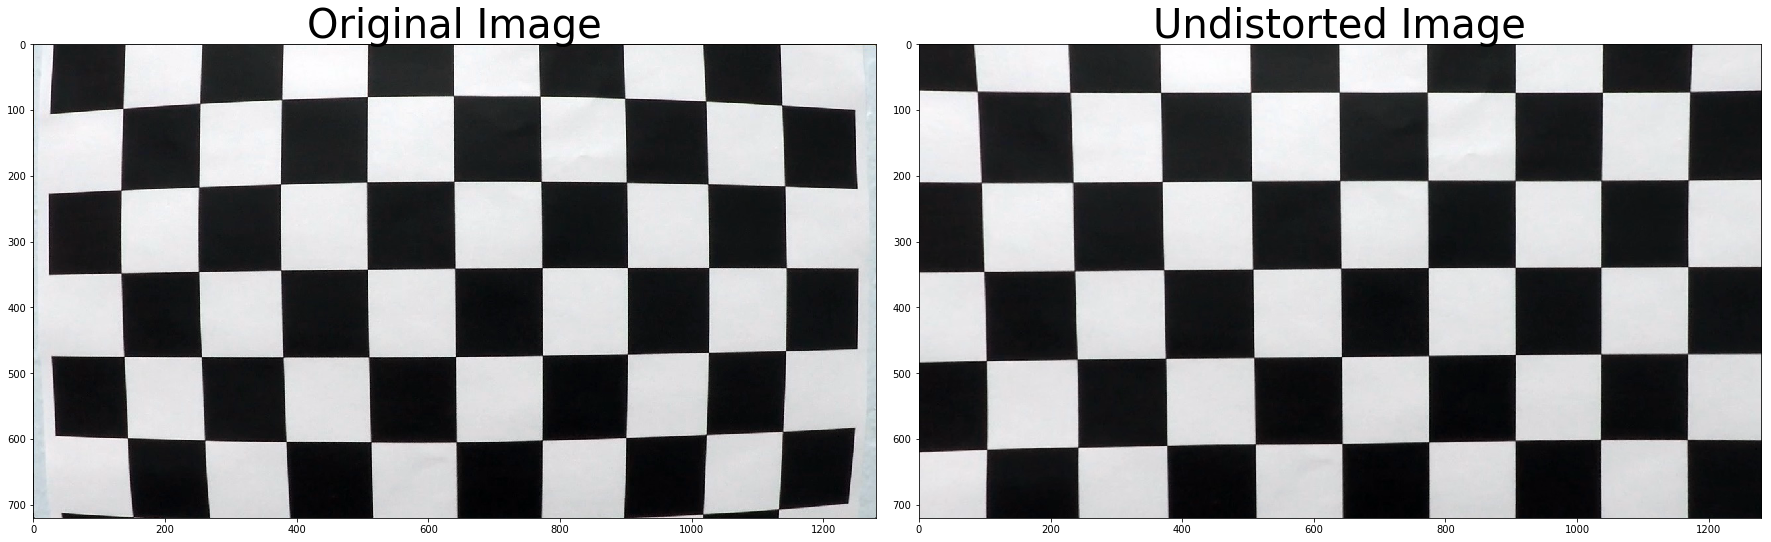

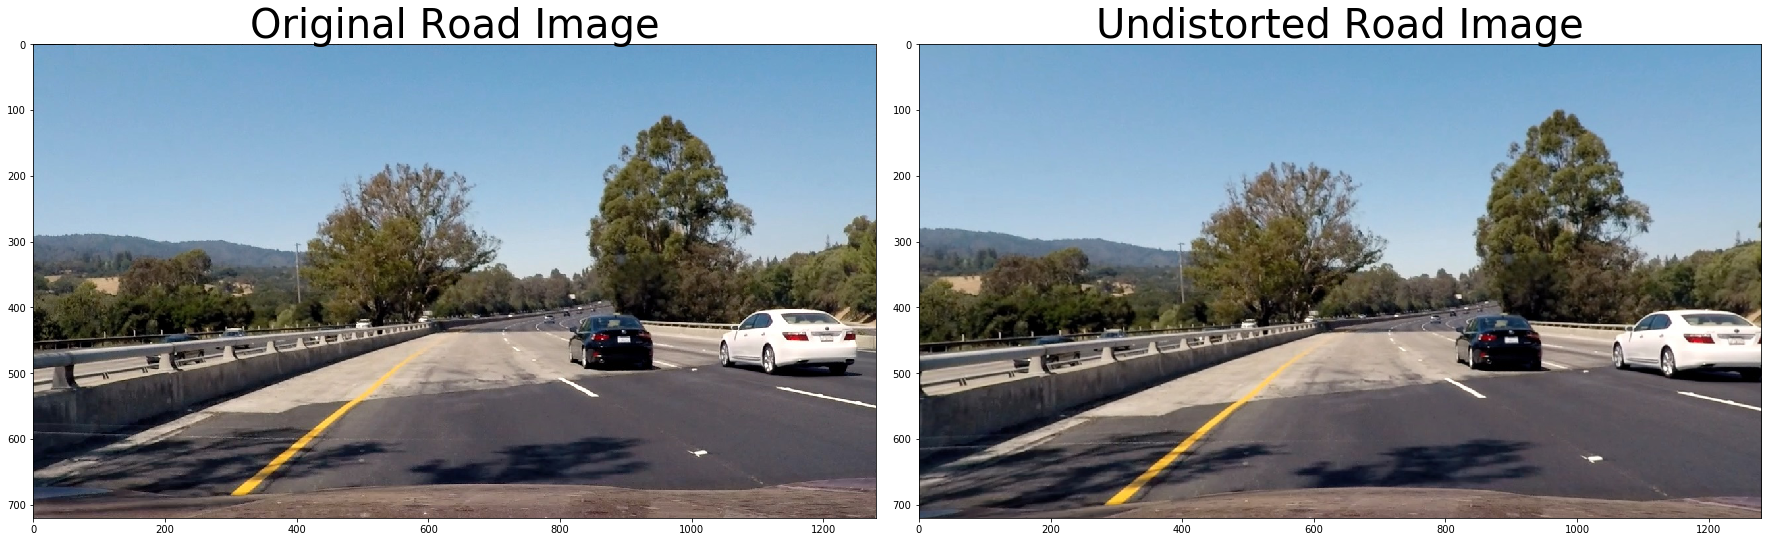

In [2]:
import os
# define output image save path
img_save_path = 'output_images/'
# define a function to undistort an image based on objpoints and imgpoints
def cal_undistort(img, objpoints, imgpoints):
    """Return undistorted image
    
    Keyword arguments:
    img -- image to be undistorted
    objpoints -- 3d points in real world space
    imgpoints -- 2d points in image plane
    """
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist
# get an example image
eg_img = cv2.imread(images[0])
eg_undistorted = cal_undistort(eg_img, objpoints, imgpoints)
# show images and save example
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(eg_img)
ax1.set_title('Original Image', fontsize=40)
ax2.imshow(eg_undistorted)
ax2.set_title('Undistorted Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
f.savefig(os.path.join(img_save_path, 'undistort_image.jpg'))

# now use test images on the road to show an example
road_images = glob.glob('./test_images/test*.jpg')
eg_rd_img = cv2.imread(road_images[3])
eg_rd_undistorted = cal_undistort(eg_rd_img, objpoints, imgpoints)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(eg_rd_img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Road Image', fontsize=40)
ax2.imshow(cv2.cvtColor(eg_rd_undistorted, cv2.COLOR_BGR2RGB))
ax2.set_title('Undistorted Road Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
f.savefig(os.path.join(img_save_path, 'undistort_road_image.jpg'))

## Use color and gradient threshold to create a binary image

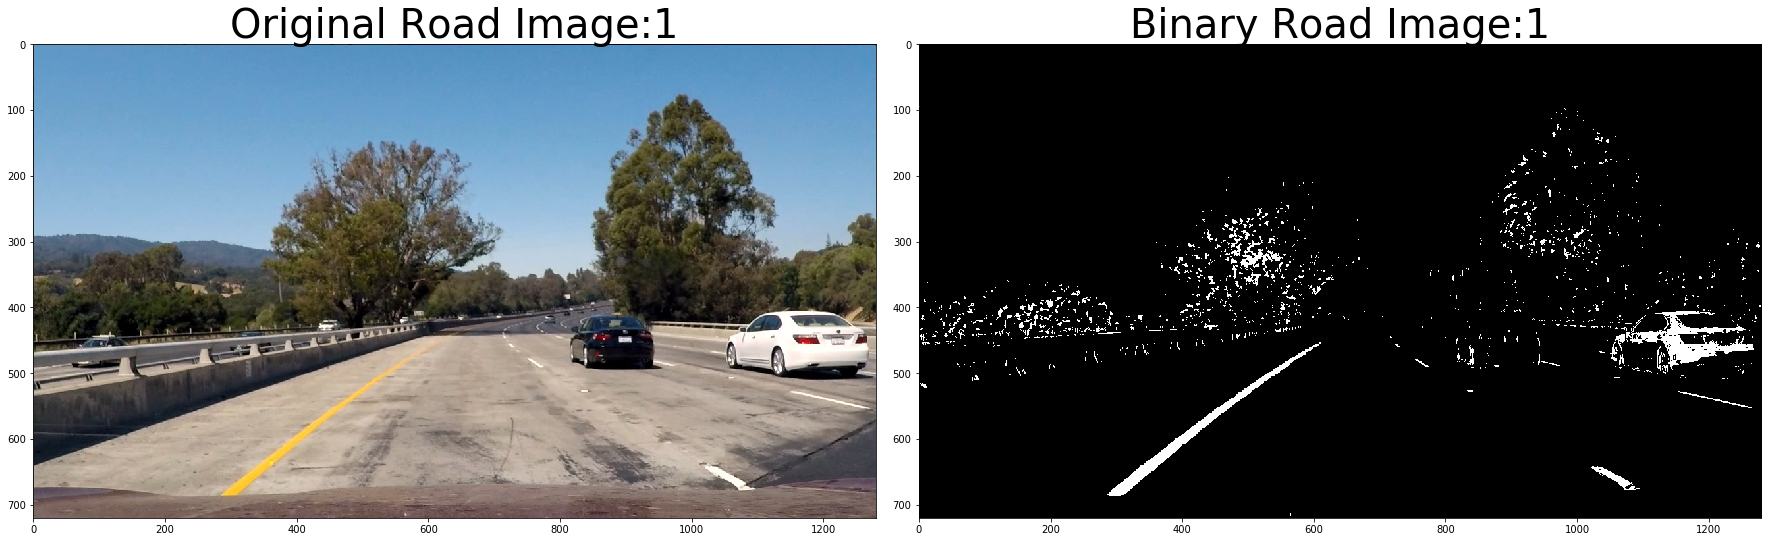

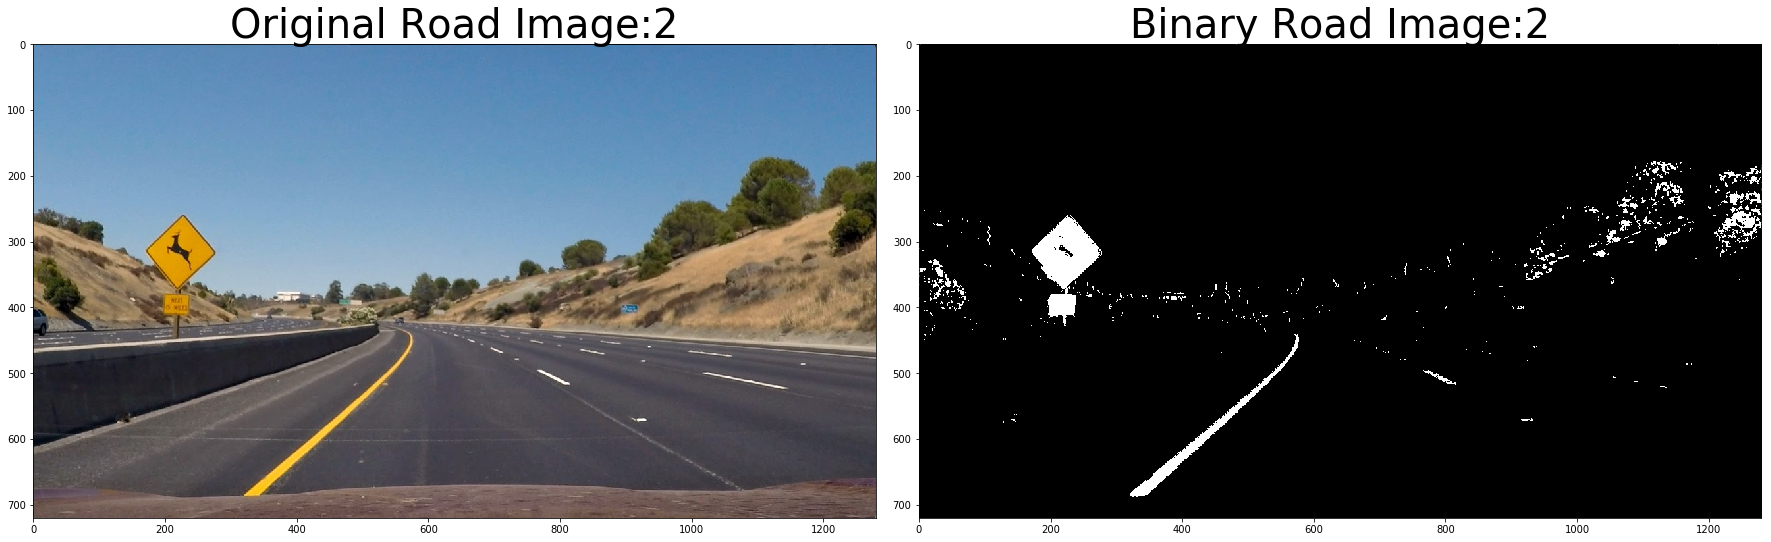

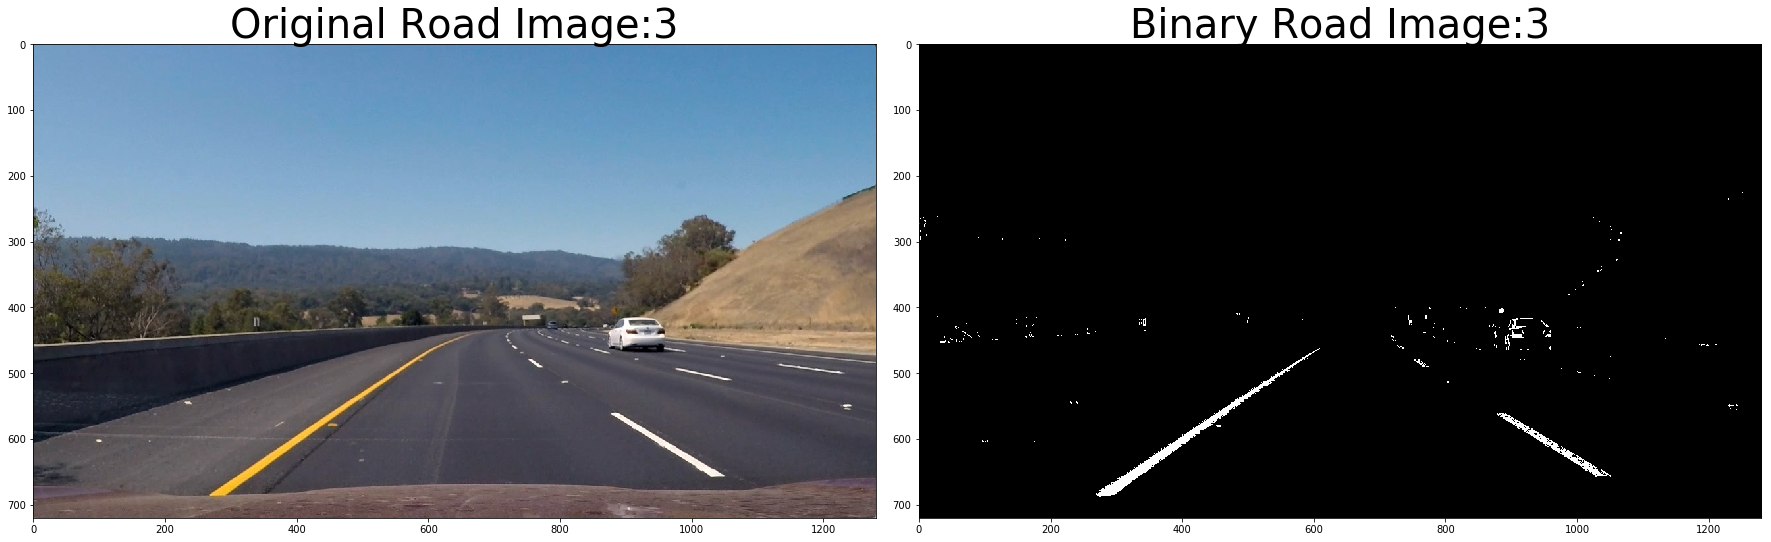

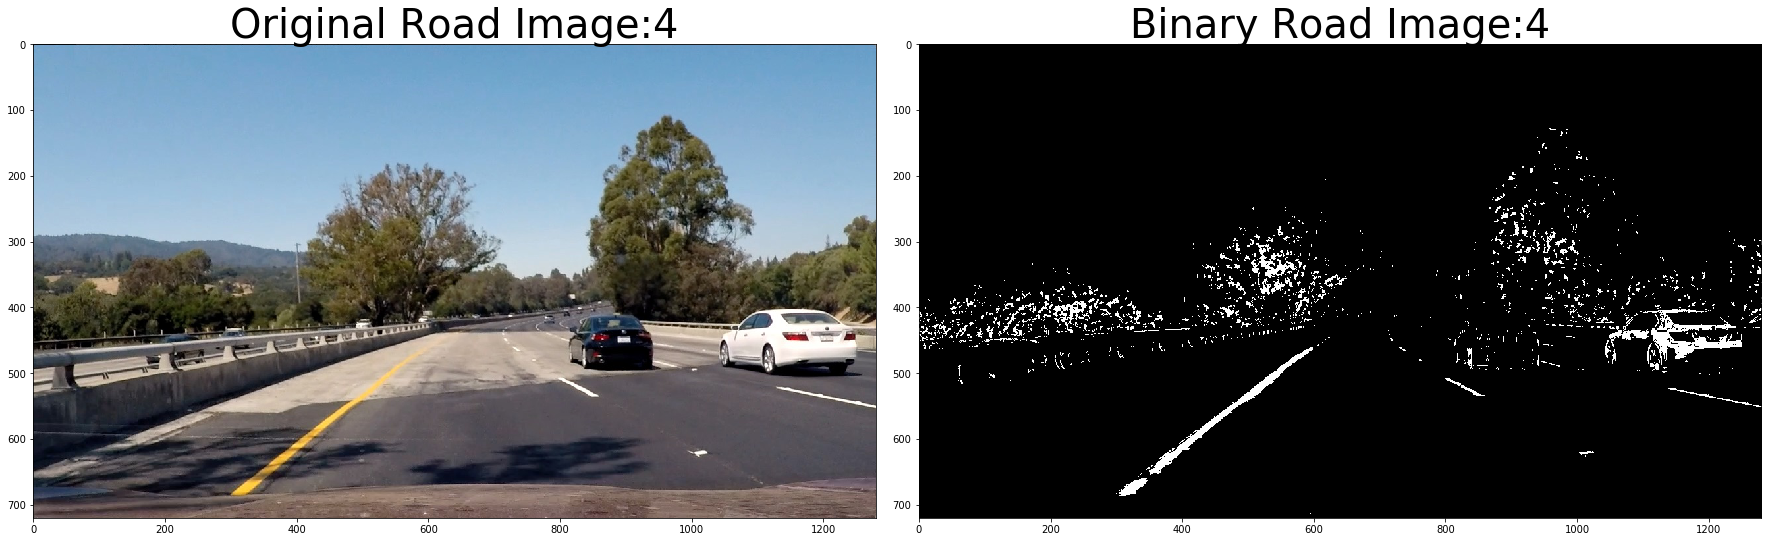

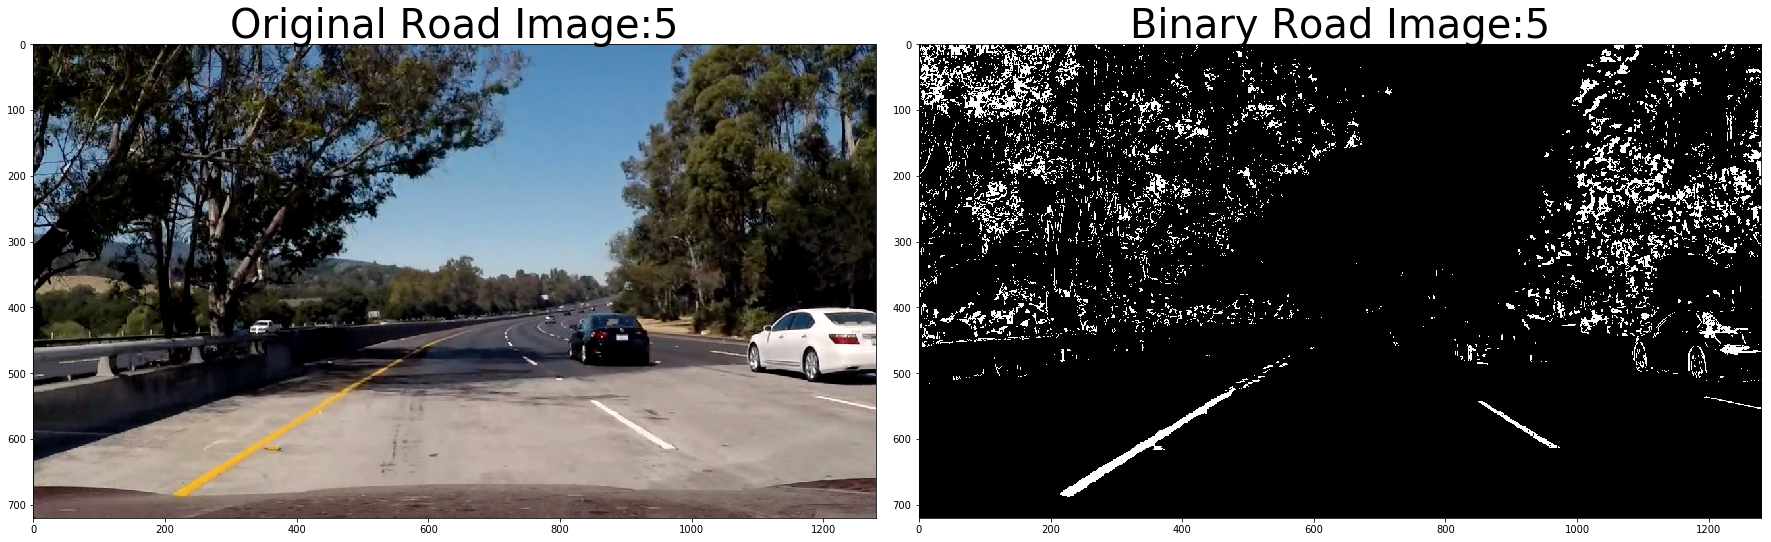

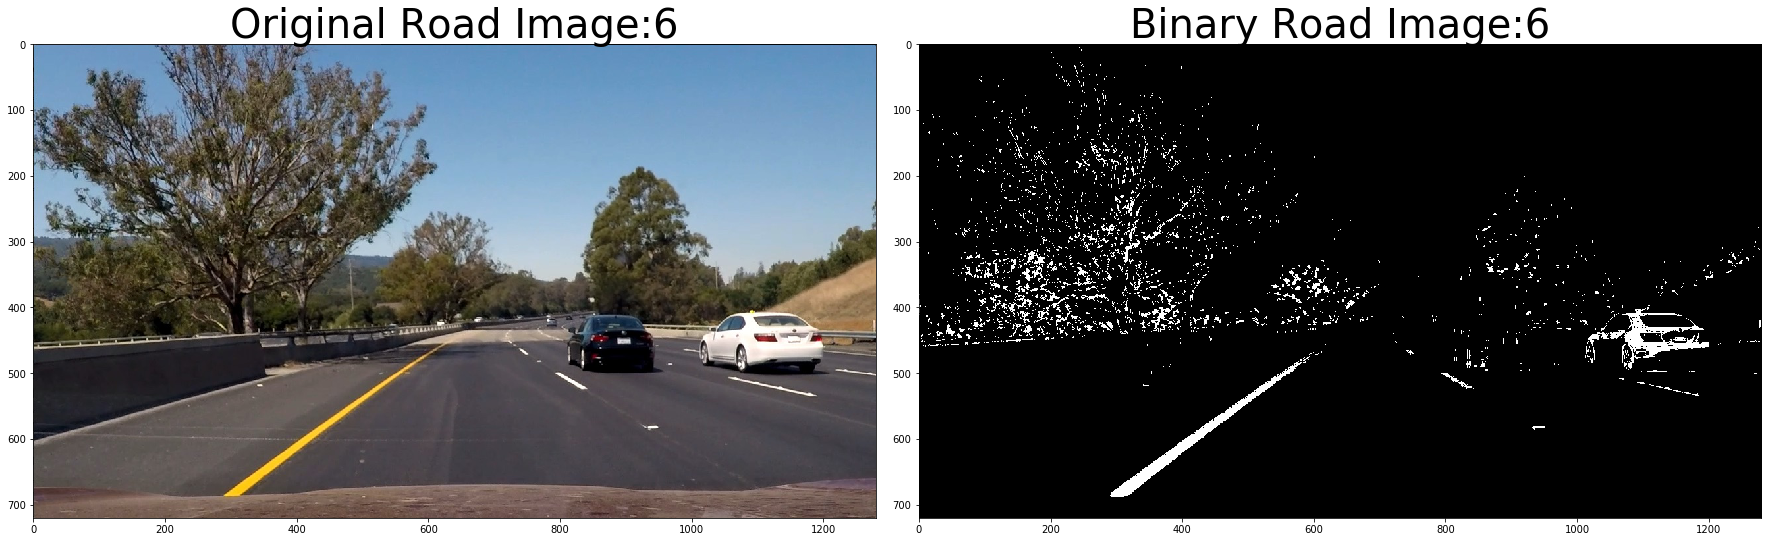

In [3]:
def binary_img(img, h_thresh_min=10, h_thresh_max=100, l_thresh_min=170, l_thresh_max=255, k_thresh_min=20, k_thresh_max=100):
    """Convert an image(BGR) into HLS space and the use color/gradient threshold to create a binary image
    
    Keyword arguments:
    img -- input image
    h_thresh_min -- lower threshold of h channel
    h_thresh_max -- upper threshold of h channel
    l_thresh_min -- lower threshold of l channel
    l_thresh_max -- upper threshold of l channel
    k_thresh_min -- lower threshold of gradient in x
    k_thresh_max -- upper threshold of gradient in x
    """
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS).astype(np.float)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    lxbinary = np.zeros_like(scaled_sobel)
    lxbinary[(scaled_sobel >= k_thresh_min) & (scaled_sobel <= k_thresh_max)] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    h_binary = np.zeros_like(h_channel)
    h_binary[(h_channel >= h_thresh_min) & (h_channel <= h_thresh_max)] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    #color_binary = np.dstack(( np.zeros_like(lxbinary), lxbinary, s_binary))
    
    # combine two binary threholds
    combined_binary = np.zeros_like(lxbinary)
    combined_binary[((s_binary == 1) & (h_binary == 1)) | (lxbinary == 1) ] = 1
    return combined_binary

# test function on all 6 test images to fine tune the parameters
h_thresh_min = 10
h_thresh_max = 100
s_thresh_min = 130
s_thresh_max = 255
k_thresh_min = 95
k_thresh_max = 255

for i, fimg in enumerate(road_images):
    img = cv2.imread(fimg)
    bin_img = binary_img(img, h_thresh_min, h_thresh_max, s_thresh_min, s_thresh_max, k_thresh_min, k_thresh_max)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax1.set_title('Original Road Image:'+str(i+1), fontsize=40)
    ax2.imshow(bin_img, cmap='gray')
    ax2.set_title('Binary Road Image:'+str(i+1), fontsize=40)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    f.savefig(os.path.join(img_save_path, 'binary_road_image'+str(i+1)+'.jpg'))

## Apply perspective transform to image

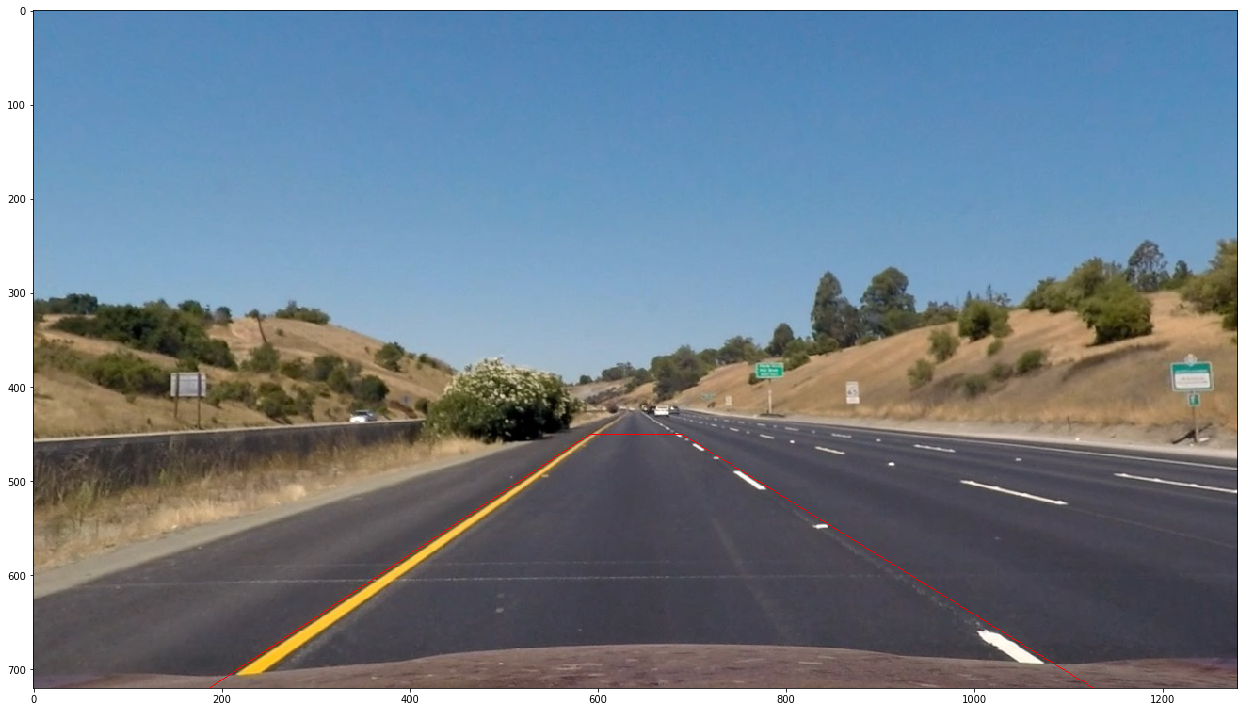

In [23]:
# use straight line image
straight1 = cv2.imread('./test_images/straight_lines1.jpg')
undist_straight1 = cal_undistort(straight1, objpoints, imgpoints)
# define a function that draws the region of interest on the image
def draw_region(img, v1, v2, v3, v4):
    img = np.copy(img)
    cv2.line(img, v1, v2, color=[0, 0, 255], thickness=1)
    cv2.line(img, v2, v3, color=[0, 0, 255], thickness=1)
    cv2.line(img, v3, v4, color=[0, 0, 255], thickness=1)
    cv2.line(img, v4, v1, color=[0, 0, 255], thickness=1)
    return img
# pick vertices
v1 = (187, undist_straight1.shape[0])
v2 = (591, 450)
v3 = (689, 450)
v4 = (1126, undist_straight1.shape[0])
# draw polygon on the image
region1 = draw_region(undist_straight1, v1, v2, v3, v4)
fig, ax = plt.subplots(figsize=(20, 10))
fig.tight_layout()
ax.imshow(cv2.cvtColor(region1, cv2.COLOR_BGR2RGB))
fig.savefig(os.path.join(img_save_path, 'vertices.jpg'))

In [24]:
# define a function to warp the image to change perspective to birds eye view
def warp(img):
    '''Compute perspective transformation M and its inverse and a warped image
    
    Keyword arguments:
    img -- input image
    '''
    img = np.copy(img)
    img_size = (img.shape[1], img.shape[0])
    # source points
    src = np.float32([v1, v2, v3, v4])
    # desination points
    dst = np.float32([[350, img_size[0]], [350, 0], [1000, 0], [1000, img_size[0]]])
    # get transformation matrix M
    M = cv2.getPerspectiveTransform(src, dst)
    # get inverse transformation matrix invM
    invM = cv2.getPerspectiveTransform(dst, src)
    # create warped image
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return (M, invM, warped)

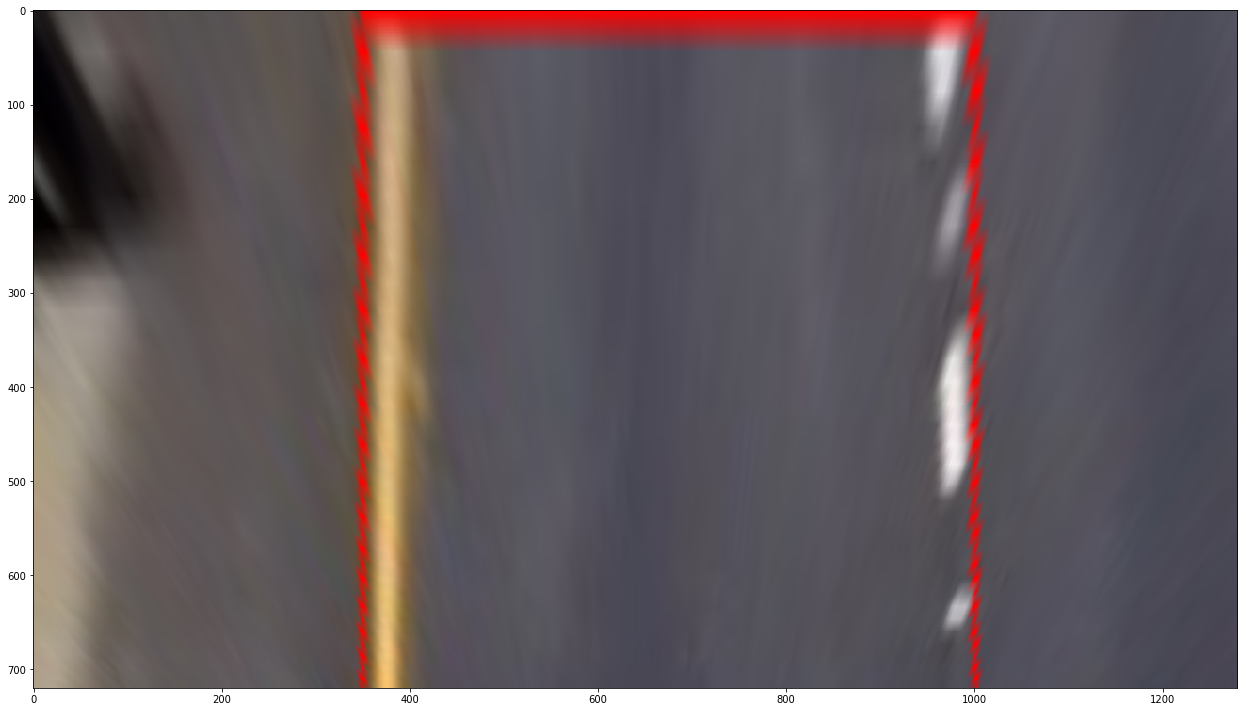

In [25]:
# test on straight line image
M, invM, warped1 = warp(region1)
fig, ax = plt.subplots(figsize=(20, 10))
fig.tight_layout()
ax.imshow(cv2.cvtColor(warped1, cv2.COLOR_BGR2RGB))
fig.savefig(os.path.join(img_save_path, 'warped.jpg'))

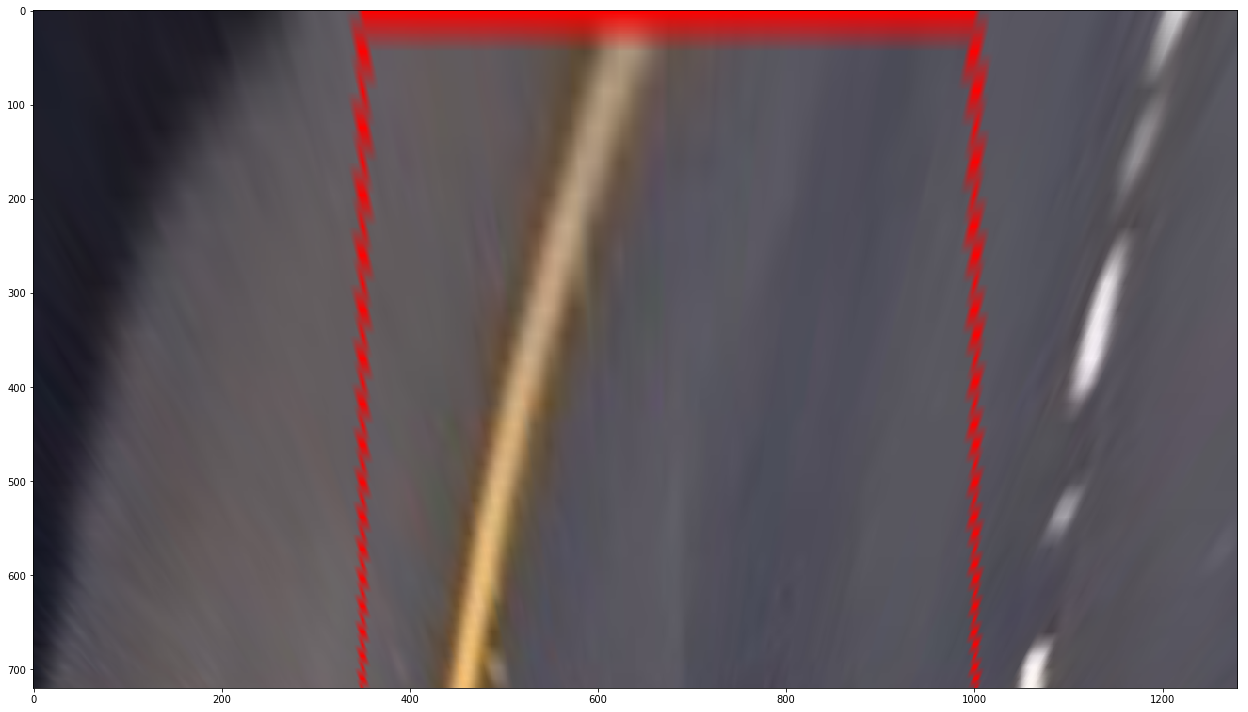

In [29]:
# test on curved image
curve_img = cv2.imread('./test_images/test3.jpg')
undist_curve_img = cal_undistort(curve_img, objpoints, imgpoints)
region2 = draw_region(undist_curve_img, v1, v2, v3, v4)
warped2 = warp(region2)[1]
fig, ax = plt.subplots(figsize=(20, 10))
fig.tight_layout()
ax.imshow(cv2.cvtColor(warped2, cv2.COLOR_BGR2RGB))
fig.savefig(os.path.join(img_save_path, 'warped2.jpg'))